In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [2]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                       transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,1,1)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
                                       ])

In [3]:
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 170498071/170498071 [00:12<00:00, 13132255.48it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [50]:

dropout_value = 0.1
group_size = 2

class Net(nn.Module):
    def __init__(self,norm = 'bn'):
        super(Net, self).__init__()
        # Input Block size = 32

        if  norm == 'bn':
            self.n1 = nn.BatchNorm2d(8)
        elif norm == 'gn':
            self.n1 = nn.GroupNorm(group_size,8)
        elif norm == 'ln':
            self.n1 = nn.GroupNorm(1,8)

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n1,
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # CONVOLUTION BLOCK 1

        if  norm == 'bn':
            self.n2 = nn.BatchNorm2d(8)
        elif norm == 'gn':
            self.n2 = nn.GroupNorm(group_size,8)
        elif norm == 'ln':
            self.n2 = nn.GroupNorm(1,8)

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n2,
            nn.Dropout(dropout_value)
        ) # output_size = 32


        if  norm == 'bn':
            self.n3 = nn.BatchNorm2d(8)
        elif norm == 'gn':
            self.n3 = nn.GroupNorm(group_size,8)
        elif norm == 'ln':
            self.n3 = nn.GroupNorm(1,8)

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n3,
            nn.Dropout(dropout_value)
        ) # output_size = 32

        # TRANSITION BLOCK 1
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 32
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 16

        # CONVOLUTION BLOCK 2

        if  norm == 'bn':
            self.n4 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n4 = nn.GroupNorm(group_size,16)
        elif norm == 'ln':
            self.n4 = nn.GroupNorm(1,16)

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n4,
            nn.Dropout(dropout_value)
        ) # output_size = 16

        if  norm == 'bn':
            self.n5 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n5 = nn.GroupNorm(group_size,16)
        elif norm == 'ln':
            self.n5 = nn.GroupNorm(1,16)

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n5,
            nn.Dropout(dropout_value)
        ) # output_size = 16

        if  norm == 'bn':
            self.n6 = nn.BatchNorm2d(16)
        elif norm == 'gn':
            self.n6 = nn.GroupNorm(group_size,16)
        elif norm == 'ln':
            self.n6 = nn.GroupNorm(1,16)

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n6,
            nn.Dropout(dropout_value)
        ) # output_size = 16

         # TRANSITION BLOCK 2
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 16
        self.pool2 = nn.MaxPool2d(2, 2) # output_size = 8

          # CONVOLUTION BLOCK 3

        if  norm == 'bn':
            self.n7 = nn.BatchNorm2d(32)
        elif norm == 'gn':
            self.n7 = nn.GroupNorm(group_size,32)
        elif norm == 'ln':
            self.n7 = nn.GroupNorm(1,32)

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n7,
            nn.Dropout(dropout_value)
        ) # output_size = 8

        if  norm == 'bn':
            self.n8 = nn.BatchNorm2d(32)
        elif norm == 'gn':
            self.n8 = nn.GroupNorm(group_size,32)
        elif norm == 'ln':
            self.n8 = nn.GroupNorm(1,32)

        self.convblock10 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n8,
            nn.Dropout(dropout_value)
        ) # output_size = 8

        if  norm == 'bn':
            self.n9 = nn.BatchNorm2d(32)
        elif norm == 'gn':
            self.n9 = nn.GroupNorm(group_size,32)
        elif norm == 'ln':
            self.n9 = nn.GroupNorm(1,32)

        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            self.n9,
            nn.Dropout(dropout_value)
        ) # output_size = 8

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=8)
        ) # output_size = 1

        self.flat = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x_temp = self.convblock1(x)
        x = self.convblock2(x_temp)
        x = self.convblock3(x) + x_temp
        x = self.convblock4(x)
        x = self.pool1(x)
        x_temp = self.convblock5(x)
        x = self.convblock6(x_temp)
        x = self.convblock7(x) + x_temp
        x = self.convblock8(x)
        x = self.pool2(x)
        x_temp = self.convblock9(x)
        x = self.convblock10(x_temp)
        x = self.convblock11(x) + x_temp
        x = self.gap(x)
        x = self.flat(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)


In [51]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net(norm='bn').to(device)
summary(model, input_size=(3, 32, 32))

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             216
              ReLU-2            [-1, 8, 32, 32]               0
       BatchNorm2d-3            [-1, 8, 32, 32]              16
       BatchNorm2d-4            [-1, 8, 32, 32]              16
           Dropout-5            [-1, 8, 32, 32]               0
            Conv2d-6            [-1, 8, 32, 32]             576
              ReLU-7            [-1, 8, 32, 32]               0
       BatchNorm2d-8            [-1, 8, 32, 32]              16
       BatchNorm2d-9            [-1, 8, 32, 32]              16
          Dropout-10            [-1, 8, 32, 32]               0
           Conv2d-11            [-1, 8, 32, 32]             576
             ReLU-12            [-1, 8, 32, 32]               0

In [52]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [53]:
model =  Net(norm='bn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH: 0


  0%|          | 0/391 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
Loss=1.4289706945419312 Batch_id=390 Accuracy=40.50: 100%|██████████| 391/391 [00:55<00:00,  7.02it/s]



Test set: Average loss: 1.5003, Accuracy: 4468/10000 (44.68%)

EPOCH: 1


Loss=1.0977414846420288 Batch_id=390 Accuracy=54.42: 100%|██████████| 391/391 [00:52<00:00,  7.42it/s]



Test set: Average loss: 1.2350, Accuracy: 5491/10000 (54.91%)

EPOCH: 2


Loss=1.0727618932724 Batch_id=390 Accuracy=59.53: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 1.1756, Accuracy: 5777/10000 (57.77%)

EPOCH: 3


Loss=1.0549108982086182 Batch_id=390 Accuracy=61.84: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 1.0712, Accuracy: 6200/10000 (62.00%)

EPOCH: 4


Loss=0.9284637570381165 Batch_id=390 Accuracy=63.90: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Average loss: 1.0225, Accuracy: 6300/10000 (63.00%)

EPOCH: 5


Loss=1.0362560749053955 Batch_id=390 Accuracy=65.44: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]



Test set: Average loss: 1.0059, Accuracy: 6444/10000 (64.44%)

EPOCH: 6


Loss=0.775338351726532 Batch_id=390 Accuracy=66.81: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]



Test set: Average loss: 0.9034, Accuracy: 6774/10000 (67.74%)

EPOCH: 7


Loss=0.9390451312065125 Batch_id=390 Accuracy=67.78: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]



Test set: Average loss: 0.8911, Accuracy: 6813/10000 (68.13%)

EPOCH: 8


Loss=0.9067323803901672 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [00:49<00:00,  7.89it/s]



Test set: Average loss: 0.8495, Accuracy: 7009/10000 (70.09%)

EPOCH: 9


Loss=0.8510316610336304 Batch_id=390 Accuracy=69.52: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 0.8688, Accuracy: 6917/10000 (69.17%)

EPOCH: 10


Loss=0.8371728658676147 Batch_id=390 Accuracy=70.38: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]



Test set: Average loss: 0.8347, Accuracy: 7058/10000 (70.58%)

EPOCH: 11


Loss=0.6953150033950806 Batch_id=390 Accuracy=71.14: 100%|██████████| 391/391 [00:49<00:00,  7.88it/s]



Test set: Average loss: 0.8159, Accuracy: 7102/10000 (71.02%)

EPOCH: 12


Loss=0.7403342723846436 Batch_id=390 Accuracy=71.45: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]



Test set: Average loss: 0.7724, Accuracy: 7305/10000 (73.05%)

EPOCH: 13


Loss=0.774168848991394 Batch_id=390 Accuracy=72.12: 100%|██████████| 391/391 [00:50<00:00,  7.82it/s]



Test set: Average loss: 0.7902, Accuracy: 7208/10000 (72.08%)

EPOCH: 14


Loss=0.7575138807296753 Batch_id=390 Accuracy=72.58: 100%|██████████| 391/391 [00:50<00:00,  7.81it/s]



Test set: Average loss: 0.7625, Accuracy: 7311/10000 (73.11%)

EPOCH: 15


Loss=0.7404299974441528 Batch_id=390 Accuracy=72.81: 100%|██████████| 391/391 [00:49<00:00,  7.87it/s]



Test set: Average loss: 0.7487, Accuracy: 7362/10000 (73.62%)

EPOCH: 16


Loss=0.8604324460029602 Batch_id=390 Accuracy=73.56: 100%|██████████| 391/391 [00:49<00:00,  7.92it/s]



Test set: Average loss: 0.7554, Accuracy: 7360/10000 (73.60%)

EPOCH: 17


Loss=0.7804322242736816 Batch_id=390 Accuracy=73.42: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.7869, Accuracy: 7310/10000 (73.10%)

EPOCH: 18


Loss=0.8038226366043091 Batch_id=390 Accuracy=74.00: 100%|██████████| 391/391 [00:49<00:00,  7.84it/s]



Test set: Average loss: 0.7749, Accuracy: 7342/10000 (73.42%)

EPOCH: 19


Loss=0.7402923703193665 Batch_id=390 Accuracy=73.92: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Average loss: 0.7144, Accuracy: 7526/10000 (75.26%)



In [39]:
test_losses

[1.6380153636932373,
 1.4273936779022216,
 1.1865341972351073,
 1.1273472643852234,
 1.1021804803848267,
 1.033354866218567,
 1.0879610849380492,
 0.9190211210250855,
 0.8911854949951172,
 0.9608477130889893,
 0.9051279623031616,
 0.9463446636199951,
 0.8267721773147583,
 0.8661414056777954,
 0.8005850121498108,
 0.7826052365779876,
 0.7715962532997132,
 0.7207624795913696,
 0.7672238311767579,
 0.7615451741218567]

Text(0.5, 1.0, 'Test Accuracy')

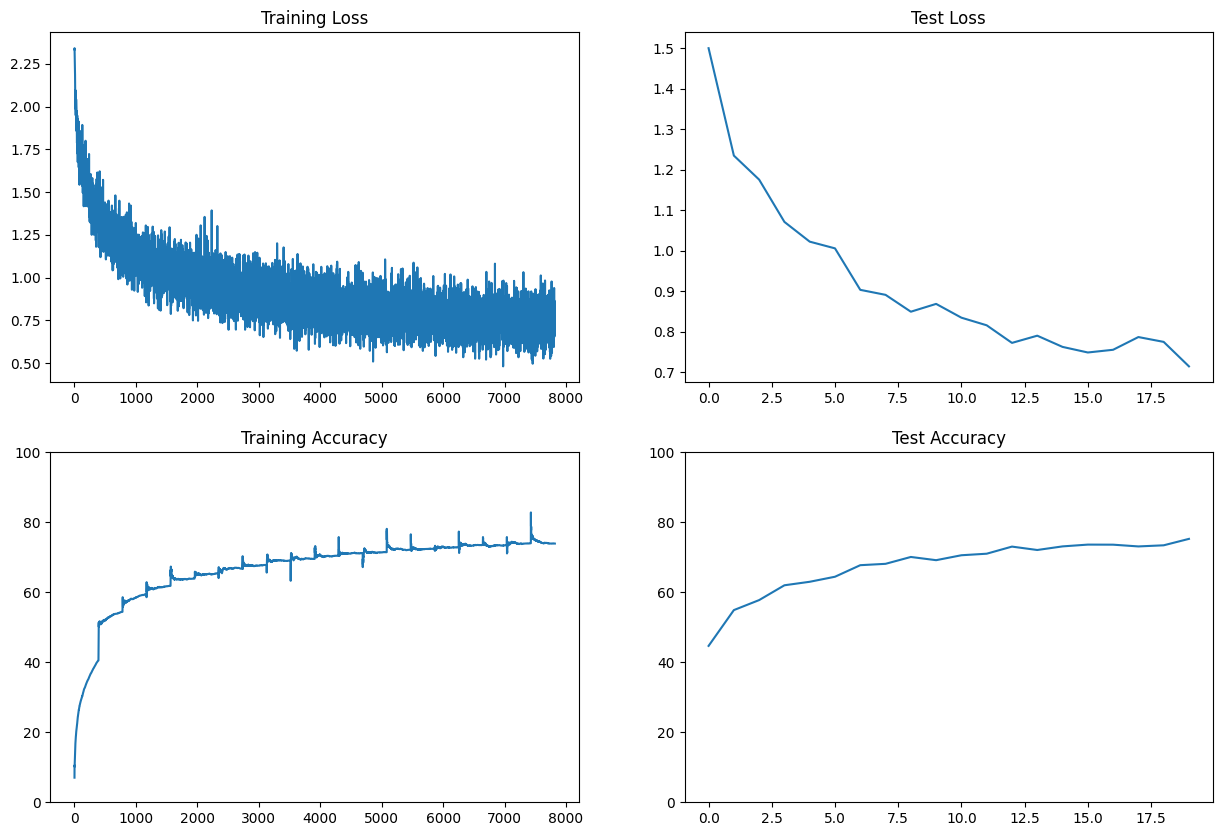

In [54]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


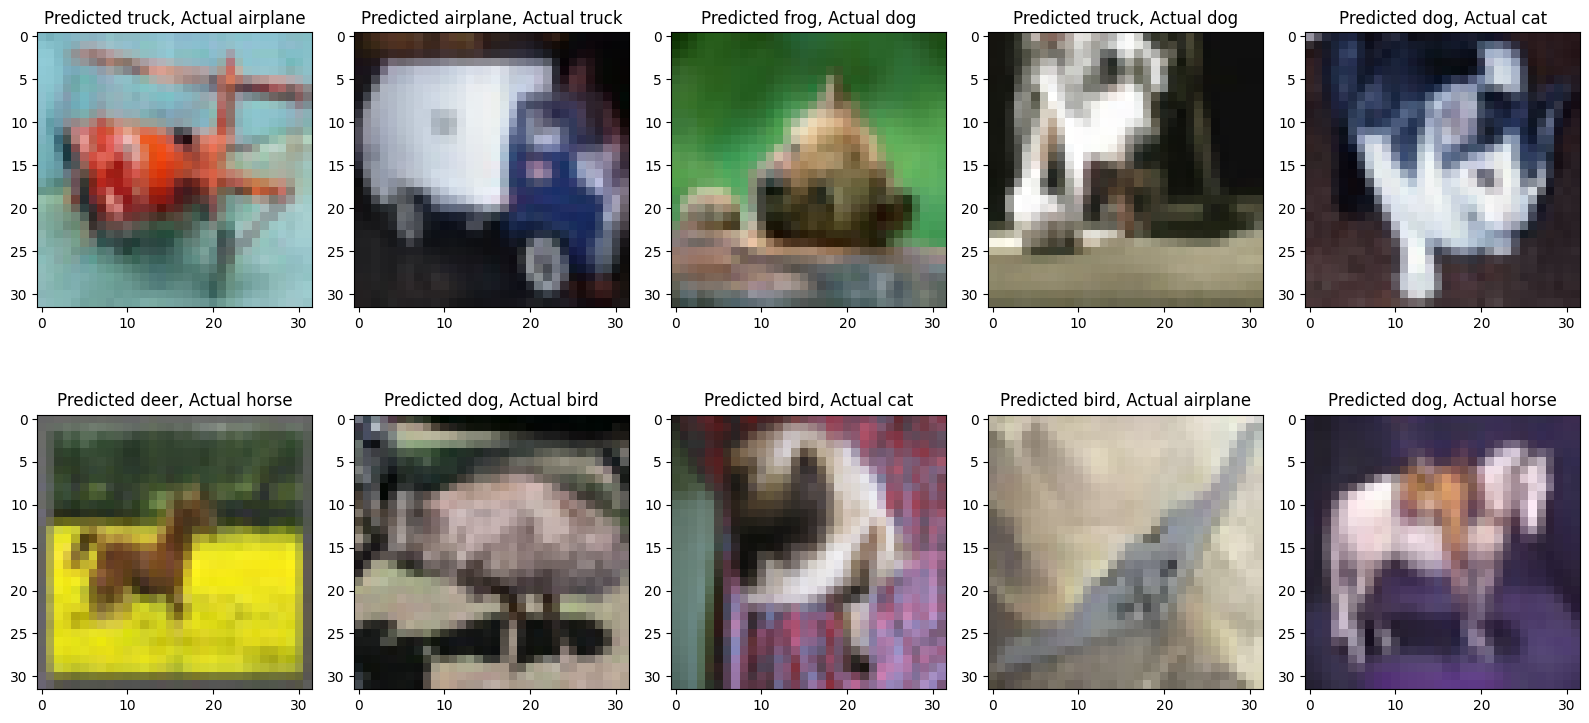

In [89]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()

In [96]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net(norm='ln').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH: 0


Loss=1.6910794973373413 Batch_id=390 Accuracy=34.16: 100%|██████████| 391/391 [00:51<00:00,  7.52it/s]



Test set: Average loss: 1.5853, Accuracy: 4038/10000 (40.38%)

EPOCH: 1


Loss=1.2940428256988525 Batch_id=390 Accuracy=46.12: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s]



Test set: Average loss: 1.3615, Accuracy: 5066/10000 (50.66%)

EPOCH: 2


Loss=1.359753131866455 Batch_id=390 Accuracy=51.44: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s]



Test set: Average loss: 1.3125, Accuracy: 5341/10000 (53.41%)

EPOCH: 3


Loss=1.1610277891159058 Batch_id=390 Accuracy=55.97: 100%|██████████| 391/391 [00:51<00:00,  7.63it/s]



Test set: Average loss: 1.1277, Accuracy: 5995/10000 (59.95%)

EPOCH: 4


Loss=0.9523059725761414 Batch_id=390 Accuracy=59.09: 100%|██████████| 391/391 [00:50<00:00,  7.80it/s]



Test set: Average loss: 1.0557, Accuracy: 6302/10000 (63.02%)

EPOCH: 5


Loss=1.0724647045135498 Batch_id=390 Accuracy=60.83: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Average loss: 1.0237, Accuracy: 6359/10000 (63.59%)

EPOCH: 6


Loss=1.01369309425354 Batch_id=390 Accuracy=62.76: 100%|██████████| 391/391 [00:50<00:00,  7.77it/s]



Test set: Average loss: 1.0169, Accuracy: 6419/10000 (64.19%)

EPOCH: 7


Loss=0.8716275095939636 Batch_id=390 Accuracy=64.17: 100%|██████████| 391/391 [00:52<00:00,  7.50it/s]



Test set: Average loss: 1.0013, Accuracy: 6454/10000 (64.54%)

EPOCH: 8


Loss=0.9601351022720337 Batch_id=390 Accuracy=65.37: 100%|██████████| 391/391 [00:50<00:00,  7.68it/s]



Test set: Average loss: 0.9583, Accuracy: 6631/10000 (66.31%)

EPOCH: 9


Loss=0.9174787402153015 Batch_id=390 Accuracy=66.40: 100%|██████████| 391/391 [00:50<00:00,  7.70it/s]



Test set: Average loss: 0.9112, Accuracy: 6828/10000 (68.28%)

EPOCH: 10


Loss=1.0168488025665283 Batch_id=390 Accuracy=66.98: 100%|██████████| 391/391 [00:49<00:00,  7.82it/s]



Test set: Average loss: 0.8667, Accuracy: 6965/10000 (69.65%)

EPOCH: 11


Loss=0.9357588887214661 Batch_id=390 Accuracy=68.03: 100%|██████████| 391/391 [00:49<00:00,  7.85it/s]



Test set: Average loss: 0.8819, Accuracy: 6860/10000 (68.60%)

EPOCH: 12


Loss=0.8097542524337769 Batch_id=390 Accuracy=68.12: 100%|██████████| 391/391 [00:49<00:00,  7.94it/s]



Test set: Average loss: 0.8420, Accuracy: 7051/10000 (70.51%)

EPOCH: 13


Loss=0.8647580146789551 Batch_id=390 Accuracy=69.15: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.8217, Accuracy: 7112/10000 (71.12%)

EPOCH: 14


Loss=0.7249375581741333 Batch_id=390 Accuracy=69.63: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.8272, Accuracy: 7068/10000 (70.68%)

EPOCH: 15


Loss=0.8033373951911926 Batch_id=390 Accuracy=70.24: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.7734, Accuracy: 7333/10000 (73.33%)

EPOCH: 16


Loss=0.9681456685066223 Batch_id=390 Accuracy=70.32: 100%|██████████| 391/391 [00:49<00:00,  7.95it/s]



Test set: Average loss: 0.8170, Accuracy: 7150/10000 (71.50%)

EPOCH: 17


Loss=0.8791815638542175 Batch_id=390 Accuracy=70.91: 100%|██████████| 391/391 [00:48<00:00,  8.04it/s]



Test set: Average loss: 0.7667, Accuracy: 7319/10000 (73.19%)

EPOCH: 18


Loss=0.8220745921134949 Batch_id=390 Accuracy=71.25: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.7975, Accuracy: 7184/10000 (71.84%)

EPOCH: 19


Loss=0.6840959191322327 Batch_id=390 Accuracy=71.50: 100%|██████████| 391/391 [00:48<00:00,  7.98it/s]



Test set: Average loss: 0.7466, Accuracy: 7383/10000 (73.83%)



Text(0.5, 1.0, 'Test Accuracy')

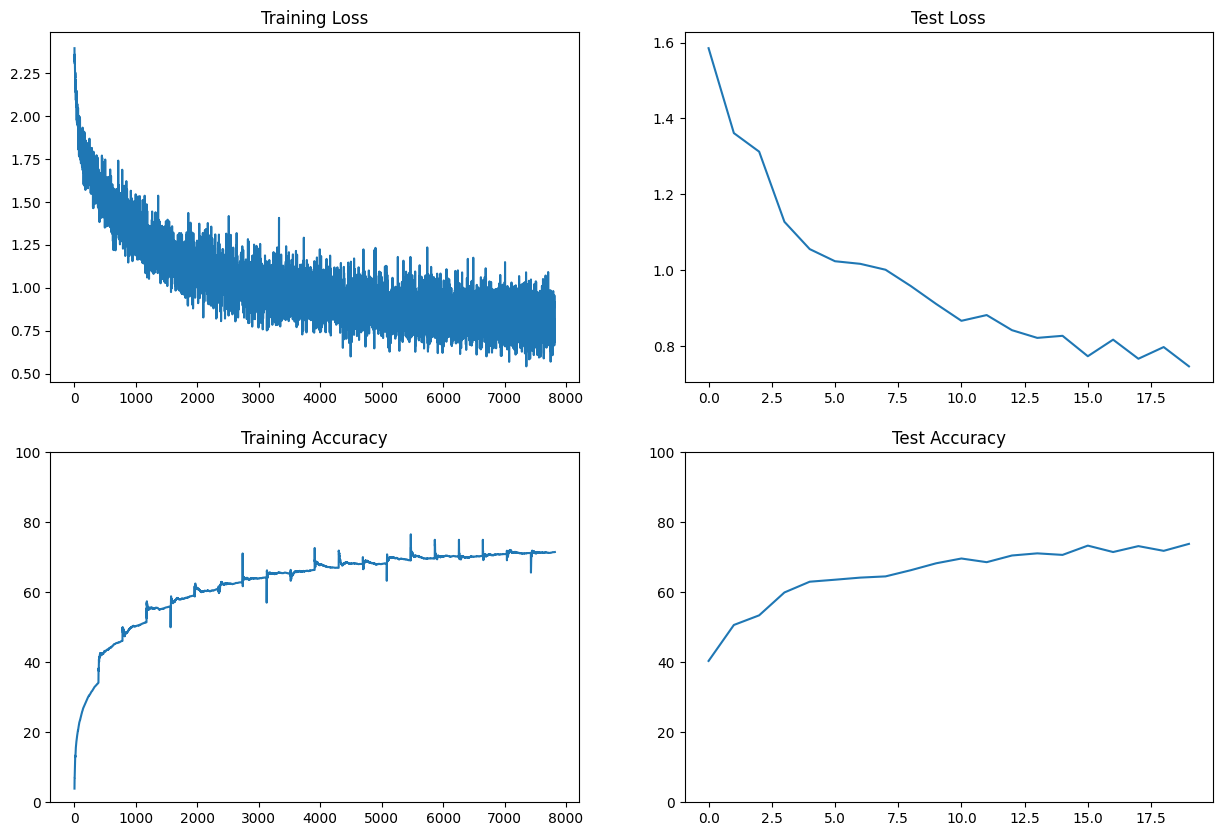

In [97]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

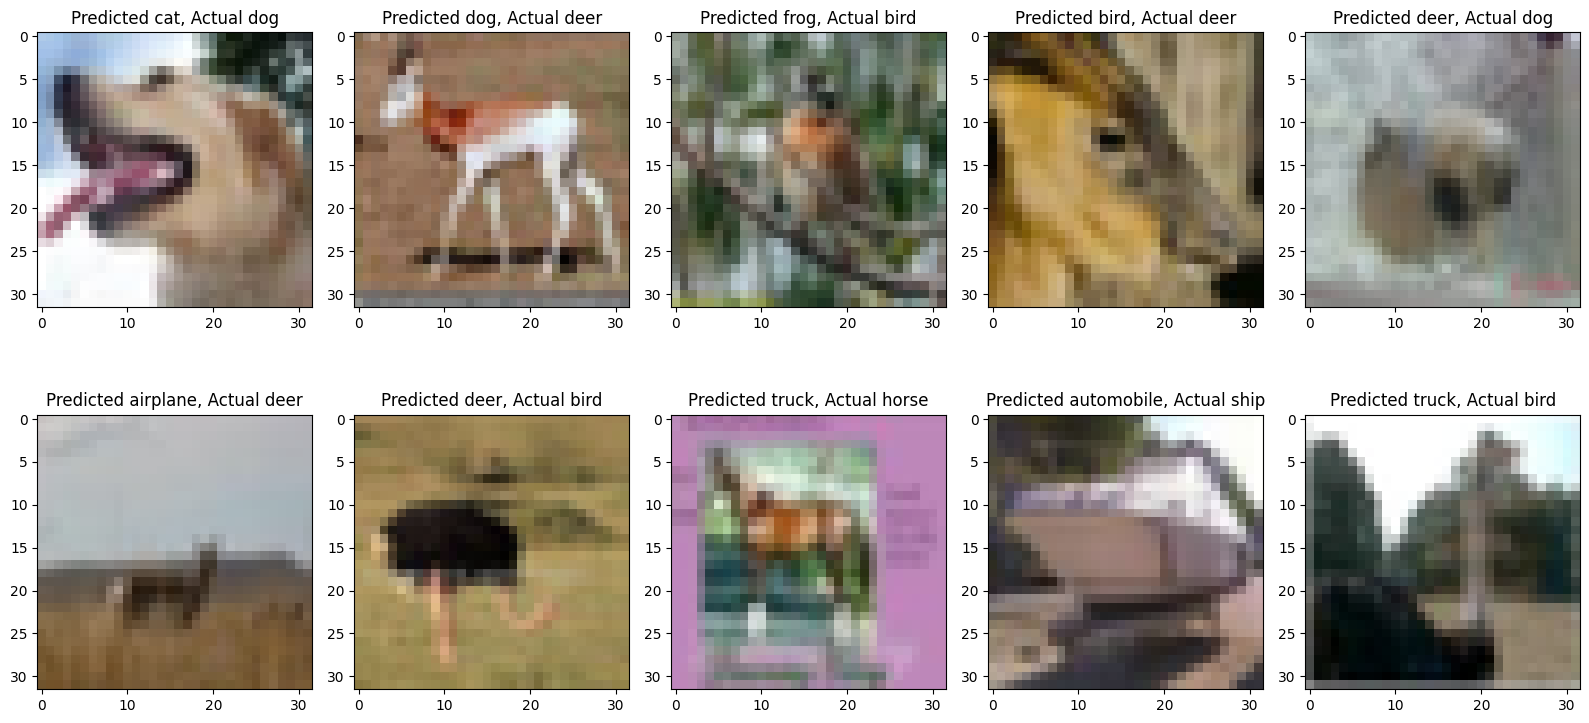

In [98]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()

In [99]:
train_losses = []
test_losses = []
train_acc = []
test_acc = []

model =  Net(norm='gn').to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model, device, train_loader, optimizer, epoch)
  test(model, device, test_loader)

EPOCH: 0


Loss=1.4583327770233154 Batch_id=390 Accuracy=32.31: 100%|██████████| 391/391 [00:49<00:00,  7.90it/s]



Test set: Average loss: 1.5245, Accuracy: 4466/10000 (44.66%)

EPOCH: 1


Loss=1.4378693103790283 Batch_id=390 Accuracy=46.12: 100%|██████████| 391/391 [00:51<00:00,  7.56it/s]



Test set: Average loss: 1.3412, Accuracy: 5152/10000 (51.52%)

EPOCH: 2


Loss=1.313109278678894 Batch_id=390 Accuracy=52.03: 100%|██████████| 391/391 [00:51<00:00,  7.66it/s]



Test set: Average loss: 1.2035, Accuracy: 5683/10000 (56.83%)

EPOCH: 3


Loss=1.3707993030548096 Batch_id=390 Accuracy=56.45: 100%|██████████| 391/391 [00:51<00:00,  7.58it/s]



Test set: Average loss: 1.2052, Accuracy: 5676/10000 (56.76%)

EPOCH: 4


Loss=1.0280859470367432 Batch_id=390 Accuracy=59.14: 100%|██████████| 391/391 [00:50<00:00,  7.73it/s]



Test set: Average loss: 1.0989, Accuracy: 6081/10000 (60.81%)

EPOCH: 5


Loss=1.198351502418518 Batch_id=390 Accuracy=61.40: 100%|██████████| 391/391 [00:50<00:00,  7.75it/s]



Test set: Average loss: 1.0047, Accuracy: 6436/10000 (64.36%)

EPOCH: 6


Loss=1.2113673686981201 Batch_id=390 Accuracy=62.34: 100%|██████████| 391/391 [00:50<00:00,  7.67it/s]



Test set: Average loss: 0.9962, Accuracy: 6466/10000 (64.66%)

EPOCH: 7


Loss=1.0643821954727173 Batch_id=390 Accuracy=64.57: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 0.9907, Accuracy: 6504/10000 (65.04%)

EPOCH: 8


Loss=0.8548467755317688 Batch_id=390 Accuracy=65.43: 100%|██████████| 391/391 [00:50<00:00,  7.74it/s]



Test set: Average loss: 0.9266, Accuracy: 6701/10000 (67.01%)

EPOCH: 9


Loss=1.125494122505188 Batch_id=390 Accuracy=66.41: 100%|██████████| 391/391 [00:49<00:00,  7.86it/s]



Test set: Average loss: 0.8980, Accuracy: 6837/10000 (68.37%)

EPOCH: 10


Loss=0.768540620803833 Batch_id=390 Accuracy=67.36: 100%|██████████| 391/391 [00:48<00:00,  8.01it/s]



Test set: Average loss: 0.8789, Accuracy: 6917/10000 (69.17%)

EPOCH: 11


Loss=1.1181373596191406 Batch_id=390 Accuracy=67.85: 100%|██████████| 391/391 [00:48<00:00,  7.99it/s]



Test set: Average loss: 0.8611, Accuracy: 6955/10000 (69.55%)

EPOCH: 12


Loss=0.9654254913330078 Batch_id=390 Accuracy=69.13: 100%|██████████| 391/391 [00:49<00:00,  7.96it/s]



Test set: Average loss: 0.8166, Accuracy: 7164/10000 (71.64%)

EPOCH: 13


Loss=0.8209063410758972 Batch_id=390 Accuracy=69.49: 100%|██████████| 391/391 [00:48<00:00,  8.05it/s]



Test set: Average loss: 0.8067, Accuracy: 7162/10000 (71.62%)

EPOCH: 14


Loss=0.8022600412368774 Batch_id=390 Accuracy=70.01: 100%|██████████| 391/391 [00:48<00:00,  8.13it/s]



Test set: Average loss: 0.7927, Accuracy: 7242/10000 (72.42%)

EPOCH: 15


Loss=0.5649646520614624 Batch_id=390 Accuracy=70.84: 100%|██████████| 391/391 [00:47<00:00,  8.23it/s]



Test set: Average loss: 0.7741, Accuracy: 7337/10000 (73.37%)

EPOCH: 16


Loss=0.7945802211761475 Batch_id=390 Accuracy=71.03: 100%|██████████| 391/391 [00:48<00:00,  8.14it/s]



Test set: Average loss: 0.7999, Accuracy: 7204/10000 (72.04%)

EPOCH: 17


Loss=0.8501896858215332 Batch_id=390 Accuracy=71.57: 100%|██████████| 391/391 [00:47<00:00,  8.21it/s]



Test set: Average loss: 0.7480, Accuracy: 7372/10000 (73.72%)

EPOCH: 18


Loss=0.8878361582756042 Batch_id=390 Accuracy=72.02: 100%|██████████| 391/391 [00:47<00:00,  8.19it/s]



Test set: Average loss: 0.7446, Accuracy: 7390/10000 (73.90%)

EPOCH: 19


Loss=0.9238139390945435 Batch_id=390 Accuracy=72.48: 100%|██████████| 391/391 [00:47<00:00,  8.20it/s]



Test set: Average loss: 0.7406, Accuracy: 7439/10000 (74.39%)



Text(0.5, 1.0, 'Test Accuracy')

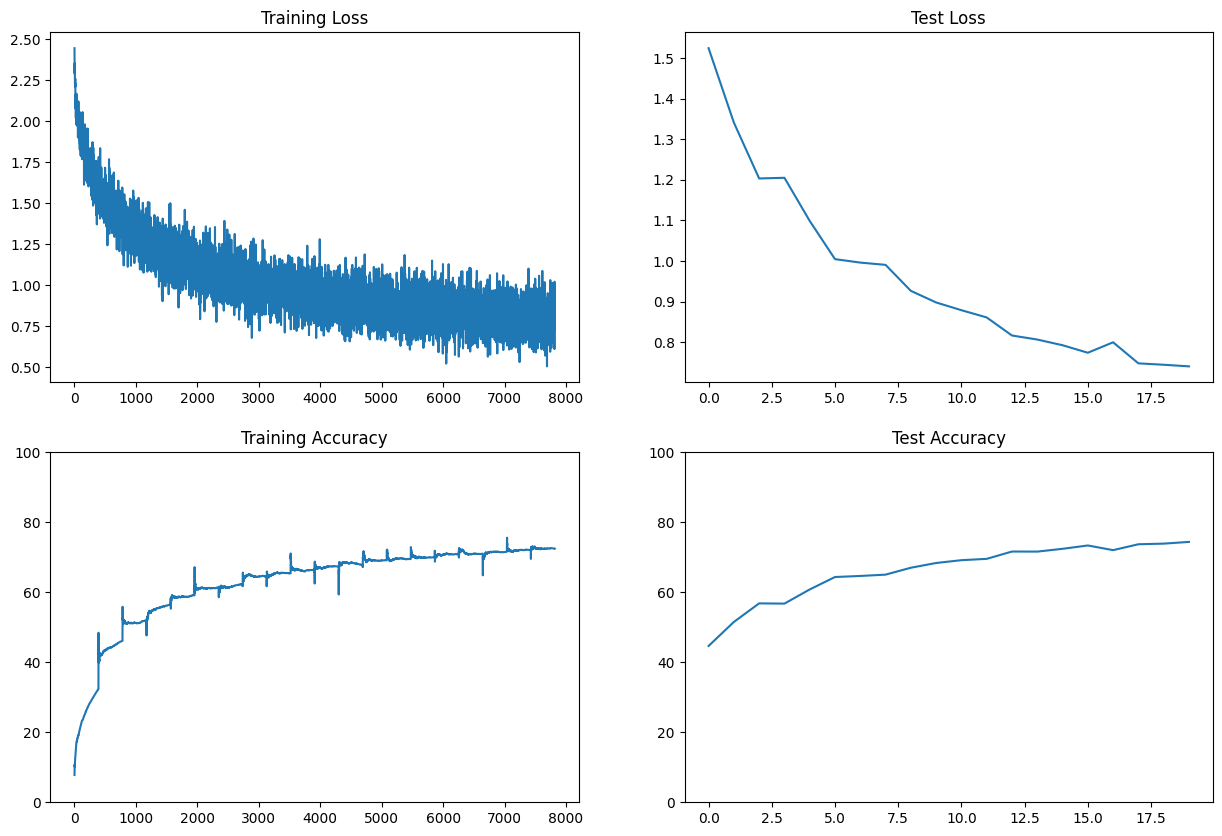

In [100]:
# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot([x.cpu().item() for x in train_losses])
axs[0, 0].set_title("Training Loss")
axs[1,0].axis(ymin=0,ymax=100)
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1,1].axis(ymin=0,ymax=100)
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

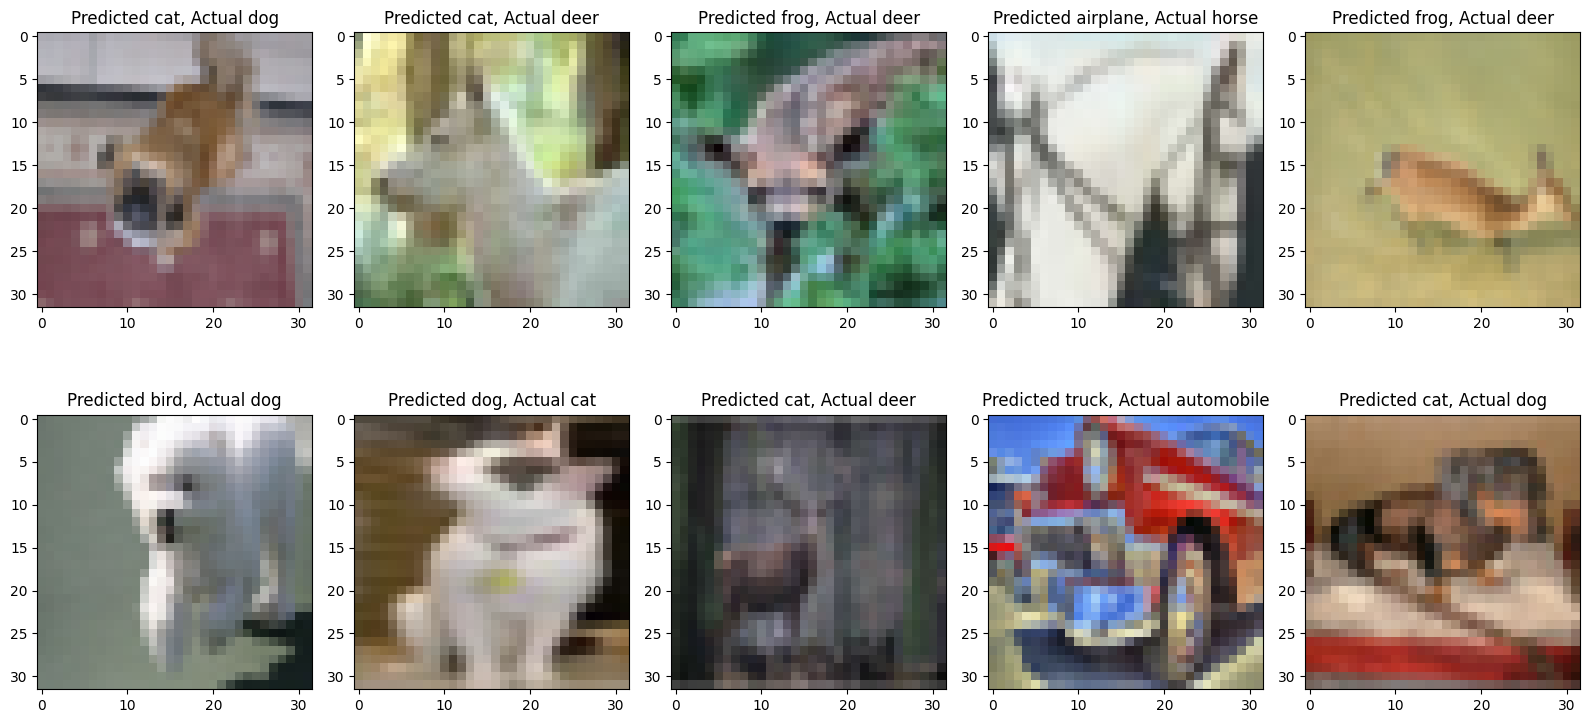

In [101]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def get_incorrect_images(model,test_loader,n=10):
  incorrect_images = []
  predicted_labels = []
  correct_labels = []
  for data, target in test_loader:
    data, target = data.to(device), target.to(device)
    output = model(data)
    pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    incorrect_items = pred.ne(target.view_as(pred))
    incorrect_indices = incorrect_items.view(-1).nonzero().view(-1)
    predicted_labels.extend([item.item() for item in pred[incorrect_indices[:n-len(incorrect_images)]]])
    correct_labels.extend([item.item() for item in target.view_as(pred)[incorrect_indices[:n-len(incorrect_images)]]])
    incorrect_images.extend([item for item in data[incorrect_indices[:n-len(incorrect_images)]]])
    if len(incorrect_images)==n:
      break
  return incorrect_images,predicted_labels,correct_labels

def imshow(img):
  img = img / 2 + 0.5     # Unnormalize
  npimg = img
  npimg = np.clip(npimg, 0, 1)  # Add this line to clip the values
  return np.transpose(npimg, (1, 2, 0))  # Convert from Tensor image

fig, axes = plt.subplots(2, 5, figsize=(16, 8))

incorrect_images,predicted_labels,correct_labels = get_incorrect_images(model,test_loader,n=10)

for i, image_tensor in enumerate(incorrect_images):
    ax = axes[i // 5, i % 5]  # Get the location of the subplot
    image = image_tensor.cpu().numpy()
    ax.imshow(imshow(image))  # Display the image
    ax.set_title(f"Predicted {class_names[predicted_labels[i]]}, Actual {class_names[correct_labels[i]]}")  # Set the title as the index

plt.tight_layout()  # To provide sufficient spacing between subplots
plt.show()